In [ ]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np,cupy as cp, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=18)
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)
rc('legend', fontsize=18)
import root_pandas,glob

import gc

def read_n(pattern, n):
    if not '*' in pattern:
        a = root_pandas.read_root(pattern,chunksize=int(n))
    else:
        a = root_pandas.read_root(glob.glob(pattern),chunksize=int(n))
    for b in a:
        del a
        print(n)
        return b

from scipy.optimize import curve_fit

image_dir='../images'

import misc_util,correlation_plots

import imp
imp.reload(correlation_plots)


plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [ ]:
dfs_mc = {a : root_pandas.read_root("/home/sebouh/CreatePairTuples/MC_Pairs_weighted_%s.root" %a,a) for a in "C Fe Pb".split()}

dfs_mc['D'] =  root_pandas.read_root("/home/sebouh/CreatePairTuples/MC_Pairs_weighted_C.root","D_C")
#dfs_mc = {a : root_pandas.read_root("/home/sebouh/CreatePairTuples/MC_Pairs_weighted_%s.root" %a,'dihadrons') for a in "D_2pi C_2pi".split()}

colors = {'D':'k','C':'r','Fe':'g','Pb':'b'}

In [ ]:
import R2h_module



for key in list(dfs_mc.keys()):
    if '_2pi' in key or '_pi_p' in key:
        continue
    df = dfs_mc[key]
    print(df.columns)
    df.eval('inelasticity = nu/5.014', inplace=True)
    df.eval('diff_phi_cm = h1_cm_ph-h2_cm_ph', inplace=True)
    df.eval('pi='+str(np.pi),inplace=True) #not sure why eval doesn't know what pi is.  
    df.eval('diff_phi_cm = 2*pi*(diff_phi_cm<-pi)-2*pi*(diff_phi_cm>pi)')
    df.eval('h1_e = h1_z*nu', inplace=True)
    df.eval('h2_e = h2_z*nu', inplace=True)
    df.eval('h2_mass = 0.13957*(abs(h2_pid)==211)+.93827208816*(abs(h2_pid)==2212)', inplace=True)
    df.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    df.eval('h2_p = sqrt(h2_e*h2_e-h2_mass*h2_mass)', inplace=True)
    df.rename(columns={'drap':'diff_rap_cm'},inplace=True)
    print(df.columns)
    dfs_mc[key+"_2pi"] = R2h_module.applyCuts(R2h_module.applyCutsPair(df,h2Proton=False,nomCuts=True),nomCuts=True)
    dfs_mc[key+"_2pi"] = dfs_mc[key+"_2pi"].query("h1_pid*h2_pid<0")
    #dfs_mc[key+"_pi_p"] = R2h_module.applyCuts(R2h_module.applyCutsPair(df,nomCuts=False,nomCuts=True),nomCuts=True)


In [ ]:
def resolution_plot_1d(xvar_recon, xvar_truth, xlabel=None, query=None, window = None):
    text = '\tmean\tstd\n'
    for key in dfs_mc.keys():
        if '_' in key: continue
        df = dfs_mc[key+'_2pi']
        if 'pass_recon' in df.keys():
            df = df.query('pass_recon')
        if query is not None:
            df = df.query(query)
            
        
        xx = df.eval(f'({xvar_recon})-({xvar_truth})')
        ww = df.weight_reco
        if window is None:
            window = 3*np.std(xx)
            ww =ww[abs(xx)<window]
            xx = xx[abs(xx)<window]
            window = 3*np.std(xx)
        ww = ww[abs(xx)<window]
        xx = xx[abs(xx)<window]
        bins = np.linspace(-window,window, 100)
        plt.gca().set_xlim(-window,window)
        #print(np.std(xx))
        
        plt.hist(xx, color =colors[key],label=key,bins=bins,histtype='step', weights=ww)
        #y,x = np.histogram(xx, bins=bins,density=True)
        #x = np.add(x[:-1],x[1:])/2
        #plt.errorbar(x,y, color = colors[key])
        #print(np.std(xx))
        text += f"    {key}\t{np.mean(xx):.3f}\t{np.std(xx):.3f}\n"
        #plt.text(0.8,0.7, text, transform=plt.gca().transAxes)
    #plt.text(-0.05, 0.6,text.expandtabs(),fontsize='medium',transform=plt.gca().transAxes, fontfamily= 'monospace')
    plt.gca().set_xlabel(xlabel + ' (recon. - gen.)')
    plt.gca().set_ylabel('events (normalized)')
    plt.gca().axhline(0,color='0.7', linestyle='--')
    plt.gca().axvline(0,color='0.7', linestyle='--')
    plt.legend()

In [ ]:
resolution_plot_1d('Q2', 'Q2_truth', xlabel='$Q^2$')

In [78]:
import os
os.mkdir('../images/resolution/')

FileNotFoundError: [Errno 2] No such file or directory: '../images/resolution/'

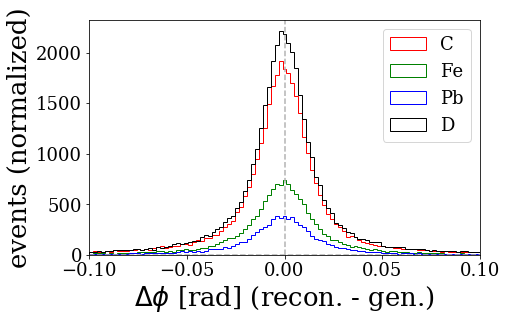

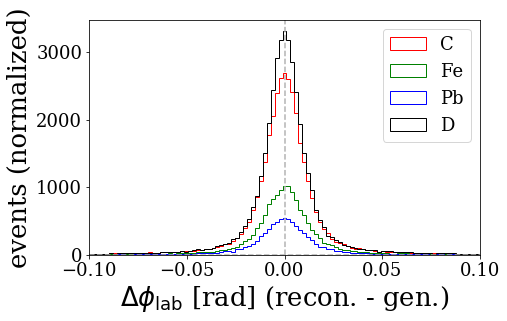

UndefinedVariableError: name 'drap' is not defined

In [79]:
resolution_plot_1d('dphi', 'dphi_truth', xlabel='$\Delta\phi}$ [rad]', window=0.1)
plt.savefig('images/resolution/res_dphi_cm.png',bbox_inches='tight')
plt.show()
resolution_plot_1d('dphi_lab', 'dphi_lab_truth', xlabel='$\Delta \phi_{\mathrm{lab}}$ [rad]', window=0.1)
plt.savefig('images/resolution/res_dphi_lab.png',bbox_inches='tight')
plt.show()
resolution_plot_1d('drap', 'drap_truth', xlabel='$\Delta y$', window=0.1)
plt.savefig('images/resolution/res_drap.png',bbox_inches='tight')
plt.show()
resolution_plot_1d('h1_z', 'h1_truth_z', xlabel='$z_1$', window=0.025)
plt.savefig('images/resolution/res_z1.png',bbox_inches='tight')
plt.show()
resolution_plot_1d('h2_z', 'h2_truth_z', xlabel='$z_2$', window=0.025)
plt.savefig('images/resolution/res_z2.png',bbox_inches='tight')
plt.show()
resolution_plot_1d('pair_mass', 'pair_mass_truth', xlabel='$m_{\mathrm{pair}}$ [GeV]', window=0.025)
plt.savefig('images/resolution/res_pair_mass.png',bbox_inches='tight')
plt.show()

In [ ]:
def recon_gen_overlay(xvar_recon, xvar_truth, xlabel=None, query=None):
    key = 'D'
    df = dfs_mc[key+'_2pi'].query('h1_truth_z>0 and h2_truth_z>0 and pair_mass<20')
    if 'pass_recon' in df.keys():
        df = df.query('pass_recon')
    if query is not None:
        df = df.query(query)
    xx = df.eval(xvar_recon)
    ww = df.weight_reco
    window = (xx.quantile(.01),xx.quantile(.99))
    plt.gca().set_xlim(*window)
    bins = np.linspace(*window, 100)
    plt.hist(xx, color =colors[key],label=key + " recon.",bins=bins,histtype='step', weights=ww, density=True)
    xx = df.eval(xvar_truth)
    ww = df.weight_reco
    plt.hist(xx, color ='#cc00cc',label=key + " gen.",bins=bins,histtype='step', weights=ww, density=True)
    plt.gca().set_xlabel(xlabel,fontsize='x-large')
    plt.gca().set_ylabel("# of events (normalized)",fontsize='x-large')
    plt.legend()

In [5]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))
def resolution_plot_slices(xvar_recon, xvar_truth, slicevar,slices=None, xlabel=None, ylabel=None, query=None, window = None,
                          bins=10):
    #text = '\tmean\tstd\n'
    
    
    for key in dfs_mc.keys():
        
        if '_' in key: continue
        df = dfs_mc[key+'_2pi'].query('h1_truth_z>0.5 and h2_truth_z>0 and pair_mass<20')
        
        
        if slices is None:
            yy = df.eval(slicevar)
            slices = np.linspace(yy.quantile(.005), yy.quantile(.995), bins)
        
        if 'pass_recon' in df.keys():
            df = df.query('pass_recon')
        if query is not None:
            df = df.query(query)
        xs = []
        ys = []
        dys = []
        for i in range(len(slices)-1):
            dfq =df.query(f'{slicevar}>{slices[i]} and {slicevar}<{slices[i+1]}')
            xx = dfq.eval(f'({xvar_recon})-({xvar_truth})')
            ww = dfq.weight_reco
            if window is None:
                window = 3*np.std(xx)
                ww = ww[abs(xx)<window]
                xx = xx[abs(xx)<window]
                window = 3*np.std(xx)
            ww = ww[abs(xx)<window]
            xx = xx[abs(xx)<window]
            xs.append((slices[i]+slices[i+1])/2)
            ys.append(weighted_avg_and_std(xx, ww)[1])
            dys.append(np.std(xx)/np.sqrt(len(xx)))
        
        #print(np.std(xx))
        
        plt.errorbar(xs,ys,dys, color =colors[key],label=key, marker='o',linestyle='')
        #y,x = np.histogram(xx, bins=bins,density=True)
        #x = np.add(x[:-1],x[1:])/2
        #plt.errorbar(x,y, color = colors[key])
        #print(np.std(xx))
        #text += f"   {key}\t{np.mean(xx):.3f}\t{np.std(xx):.3f}\n"
        #plt.text(0.8,0.7, text, transform=plt.gca().transAxes)
    #plt.text(0, 0.6,text.expandtabs(),fontsize='small',transform=plt.gca().transAxes, fontfamily= 'monospace')
    plt.gca().set_ylabel(ylabel + ' (recon. - gen.)')
    plt.gca().set_xlabel(xlabel + ' gen.')
    plt.gca().set_ylim(0)
    #plt.gca().axhline(0,color='0.7', linestyle='--')
    #plt.gca().axvline(0,color='0.7', linestyle='--')
    plt.legend()

In [81]:
def threePanels(recon,truth,label,window=None, query=None,bins=10,slices=None):
    fig,axs = plt.subplots(1,3,figsize=(21,7))
    plt.sca(axs[0])
    recon_gen_overlay(recon, truth, xlabel=label, query=query)
    plt.sca(axs[1])
    resolution_plot_1d(recon, truth, xlabel=label,query=query,window=window)
    plt.sca(axs[2])
    resolution_plot_slices(recon, truth, truth, xlabel=label, 
                           ylabel=label,query=query,window=window,bins=bins,slices=slices)
    fig.tight_layout()


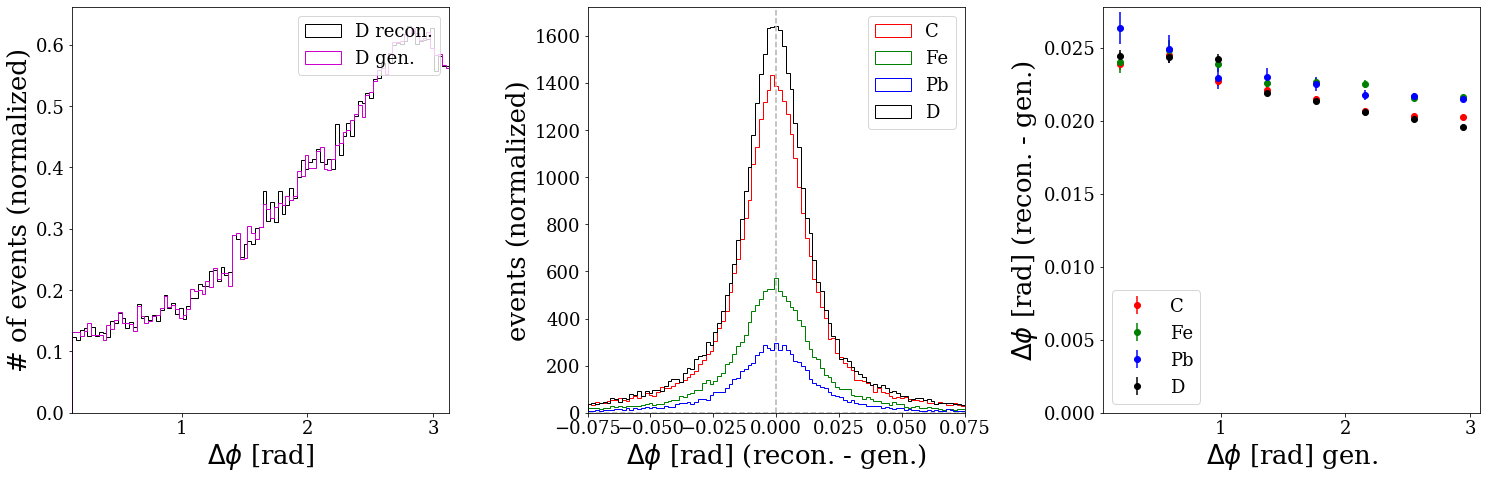

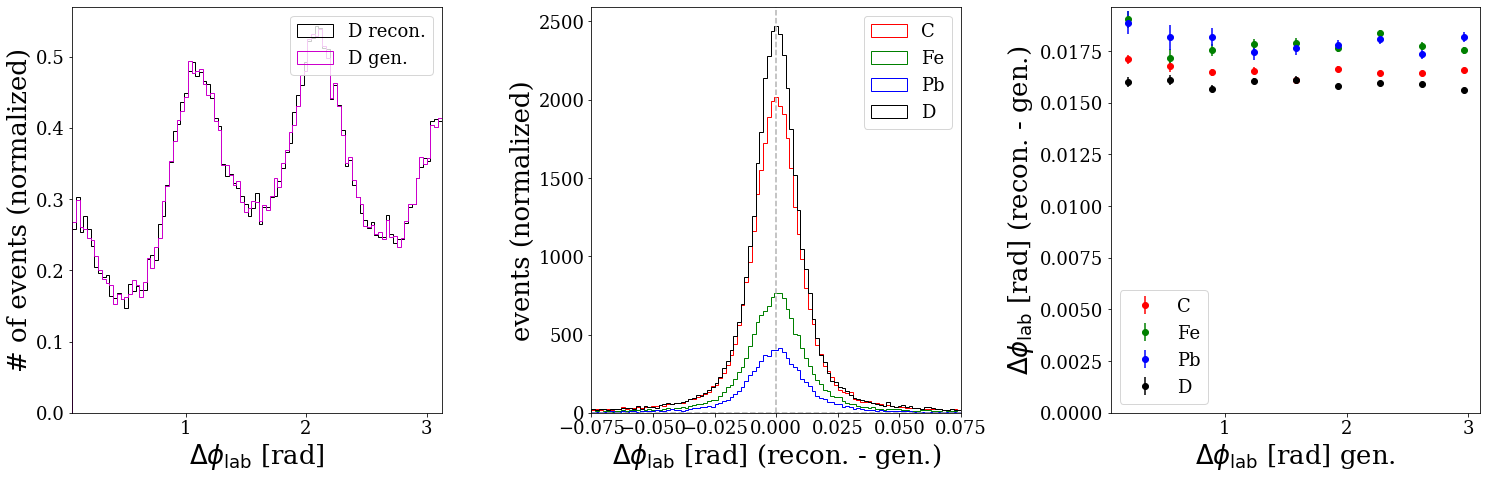

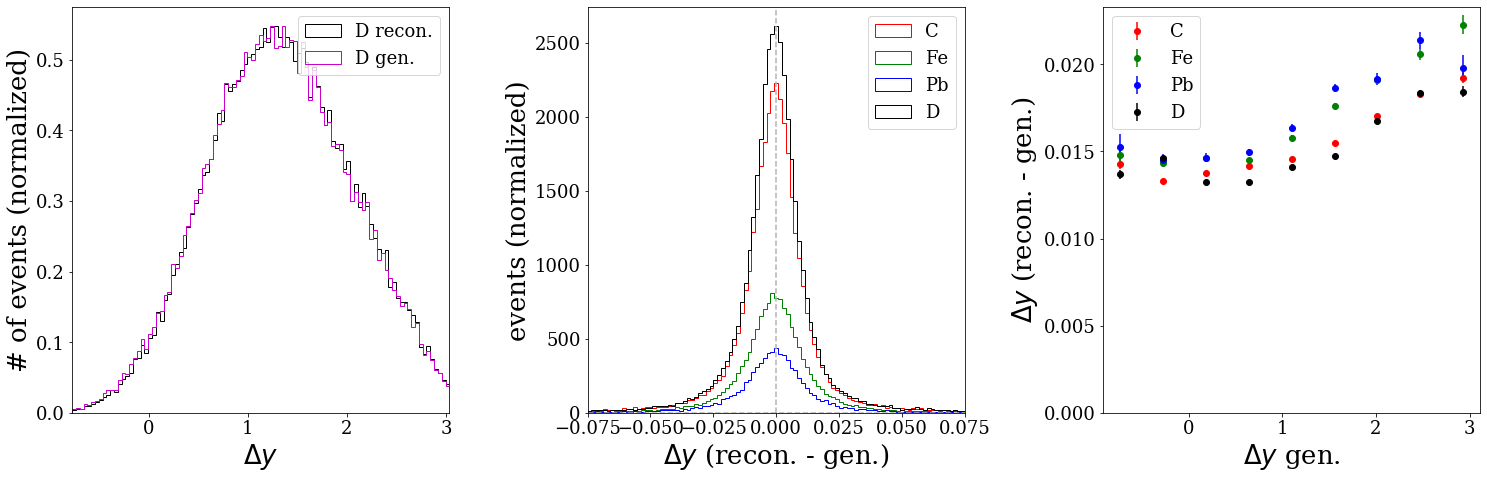

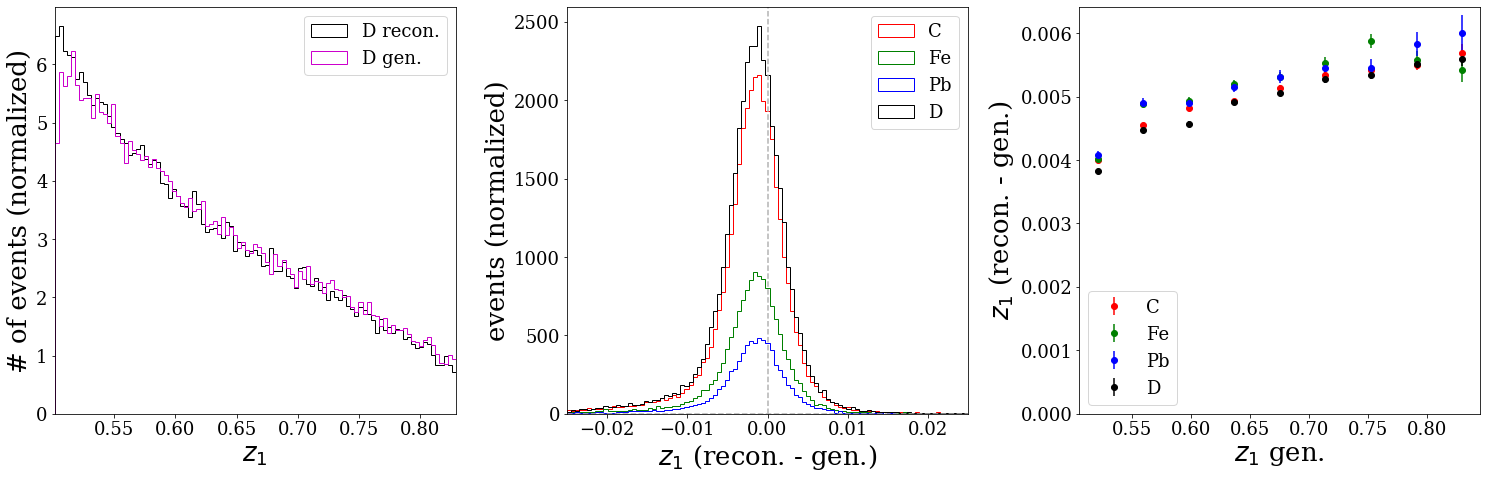

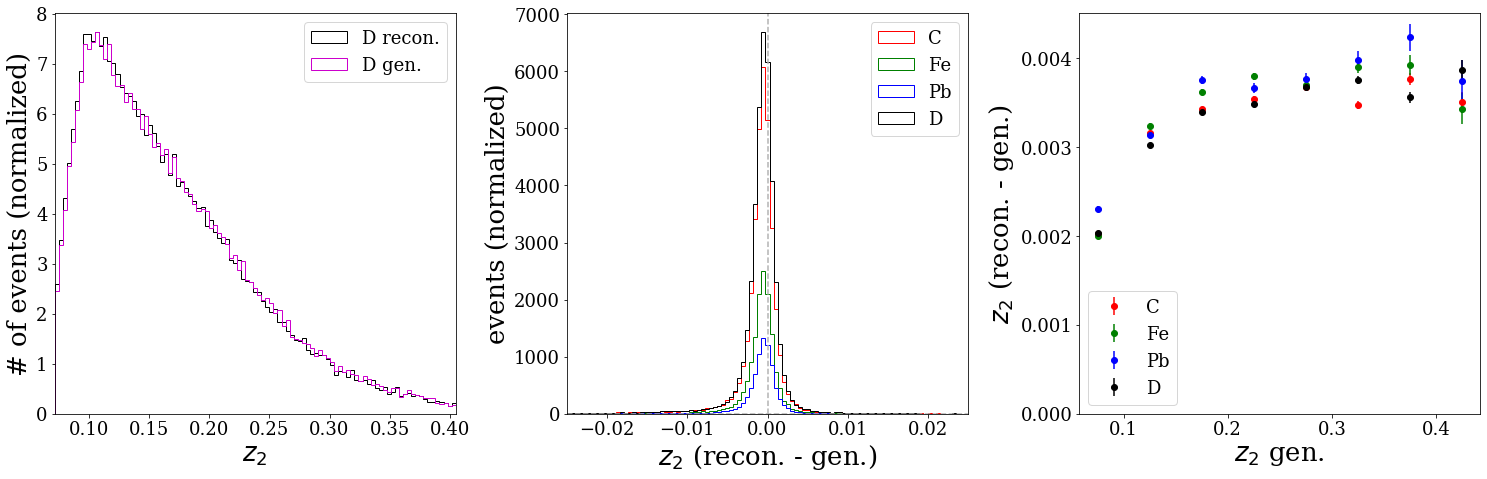

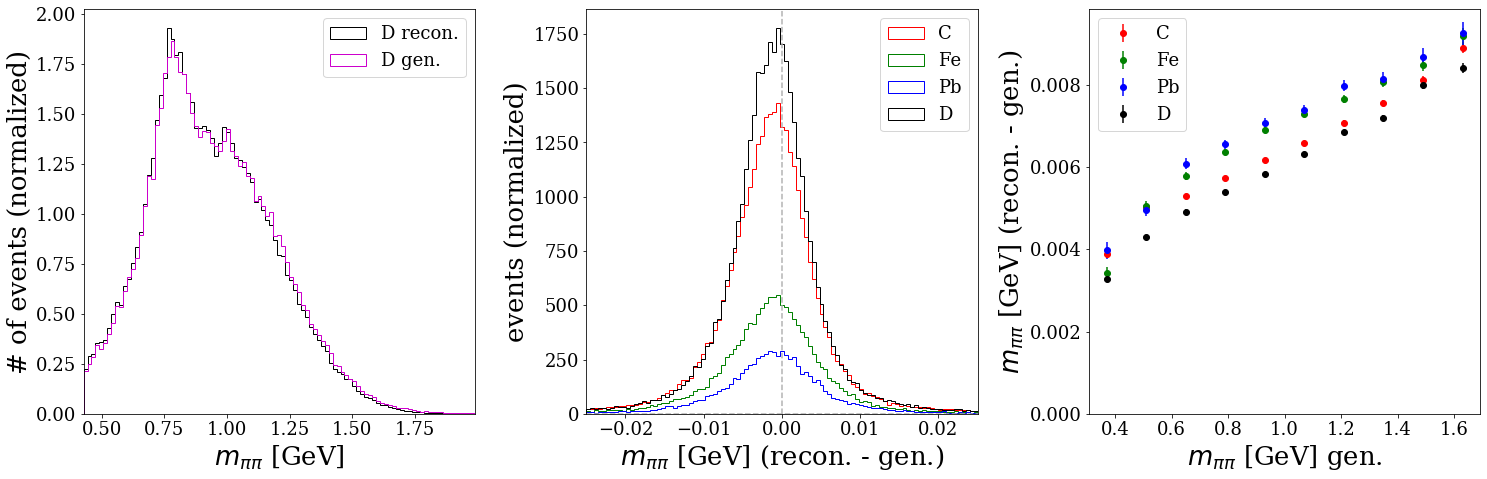

In [82]:
threePanels('dphi', 'dphi_truth', '$\Delta\phi$ [rad]', window=0.075,slices=np.linspace(0,3.14,9))
plt.savefig('images/resolution/res_dphi_cm.png',bbox_inches='tight')
plt.show()
threePanels('dphi_lab', 'dphi_lab_truth', '$\Delta \phi_{\mathrm{lab}}$ [rad]', window=0.075)
plt.savefig('images/resolution/res_dphi_lab.png',bbox_inches='tight')
plt.show()
threePanels('diff_rap_cm', 'drap_truth', '$\Delta y$', window=0.075)
plt.savefig('images/resolution/res_drap.png',bbox_inches='tight')
plt.show()
threePanels('h1_z', 'h1_truth_z', '$z_1$', window=0.025)
plt.savefig('images/resolution/res_z1.png',bbox_inches='tight')
plt.show()
threePanels('h2_z', 'h2_truth_z', '$z_2$', window=0.025,slices=np.linspace(0.05,.45,9))
plt.savefig('images/resolution/res_z2.png',bbox_inches='tight')
plt.show()
threePanels('pair_mass', 'pair_mass_truth', '$m_{\\pi\\pi}$ [GeV]', window=0.025,slices=np.linspace(.3,1.7,11))
plt.savefig('images/resolution/res_pair_mass.png',bbox_inches='tight')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../images/resolution/res_dphi_cm_slices.png'

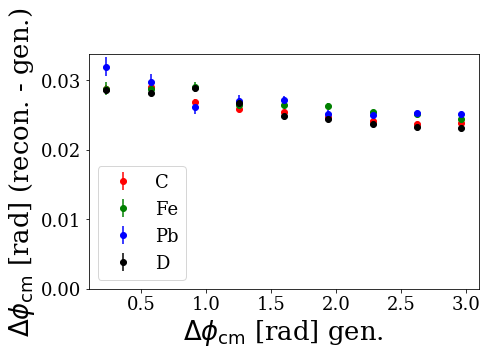

In [83]:
resolution_plot_slices('dphi', 'dphi_truth','dphi_truth', xlabel='$\Delta\phi_{\mathrm{cm}}$ [rad]',ylabel='$\Delta\phi_{\mathrm{cm}}$ [rad]', window=0.1)
plt.savefig('../images/resolution/res_dphi_cm_slices.png',bbox_inches='tight')
plt.show()
resolution_plot_slices('dphi_lab', 'dphi_lab_truth','dphi_lab_truth', xlabel='$\Delta \phi_{\mathrm{lab}}$ [rad]', ylabel='$\Delta \phi_{\mathrm{lab}}$ [rad]', window=0.1)
plt.savefig('../images/resolution/res_dphi_lab_slices.png',bbox_inches='tight')
plt.show()
resolution_plot_slices('drap', 'drap_truth','drap_truth', xlabel='$\Delta y_{\mathrm{cm}}$',ylabel='$\Delta y_{\mathrm{cm}}$', window=0.1)
plt.savefig('../images/resolution/res_drap_slices.png',bbox_inches='tight')
plt.show()
resolution_plot_slices('h1_z', 'h1_truth_z','h1_truth_z', xlabel='$z_1$',ylabel='$z_1$', window=0.025)
plt.savefig('../images/resolution/res_z1_slices.png',bbox_inches='tight')
plt.show()
resolution_plot_slices('h2_z', 'h2_truth_z','h2_truth_z', xlabel='$z_2$',ylabel='$z_2$', window=0.025)
plt.savefig('../images/resolution/res_z2_slices.png',bbox_inches='tight')
plt.show()
resolution_plot_slices('pair_mass', 'pair_mass_truth','pair_mass_truth', xlabel='$m_{\mathrm{pair}}$ [GeV]', ylabel='$m_{\mathrm{pair}}$ [GeV]', window=0.025)
plt.savefig('../images/resolution/res_pair_mass_slices.png',bbox_inches='tight')
plt.show()

In [ ]:
plt.hist(dfs_mc['D'].dphi)

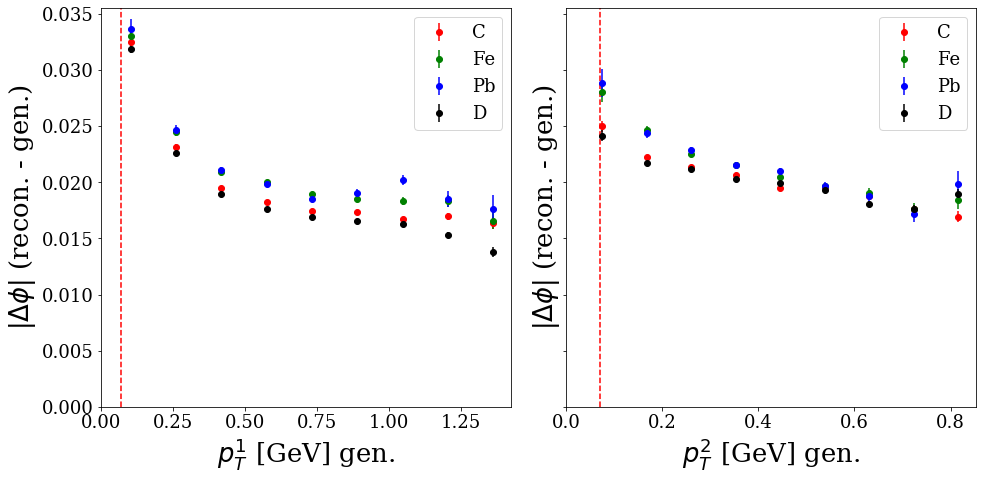

In [24]:
fig,axs = plt.subplots(1,2, figsize=(14,7), sharey='all')
xvar_recon="dphi"
xvar_truth="dphi_truth"
ylabel="$|\Delta\phi|$"
for slice_var,xlabel,ax in [("h1_truth_cm_pt","$p^1_T$ [GeV]",axs[0]),
                ("h2_truth_cm_pt","$p^2_T$ [GeV]",axs[1])]:
    plt.sca(ax)
    resolution_plot_slices(xvar_recon, xvar_truth, slicevar=slice_var, xlabel=xlabel, window=0.075,ylabel=ylabel,
                          bins=10,query='h1_truth_cm_pt>sqrt(0.005) and h2_truth_cm_pt>sqrt(0.005)')
    plt.axvline(np.sqrt(0.005), color='r', linestyle='--')
    plt.gca().set_xlim(0)
fig.tight_layout()
plt.savefig("images/res_dphi_pt.png")
    

In [18]:
np.dradfs_mc['D_2pi'].h1_truth_pt

{'C':             dphi  dphi_lab  diff_rap_cm      h1_z      h2_z  h1_cm_pt  \
 entry                                                                   
 0       0.274535  0.779032     1.771045  0.590539  0.173355  0.079696   
 1       1.426866  1.829815     1.166516  0.539039  0.185180  0.661640   
 2       1.175350  1.235881     2.360048  0.637286  0.087167  0.226276   
 3       0.856784  0.501195     1.501921  0.444425  0.122687  0.390975   
 4       2.117856  1.648076     0.925466  0.421767  0.323843  0.527161   
 ...          ...       ...          ...       ...       ...       ...   
 288958  3.000450  1.675658     0.696713  0.686940  0.265126  0.413522   
 288959  2.676058  2.292465     1.128227  0.446357  0.098894  0.690269   
 288960  2.790725  2.779422     3.432914  0.776161  0.133509  0.074210   
 288961  2.757120  3.077286    -0.212696  0.490745  0.254078  0.982427   
 288962  3.052337  2.223684     0.371126  0.439590  0.309129  0.593967   
 
         h2_cm_pt     h1_xf    